# Key definition Hearth system
- Atrial (top champer) - controller the rythms
- Ventricles (bottom chambers) - controller the pumping
---
***Atrial Fibrillation is a problem of the atria not thhe ventricles***

---

## LSTM & SMOTE Intermidate model (three model layer based(LSTM, SMOTE, ValidationResult))
### Implementation of LSTM
- split with patient-id
- z-score normalization
- windows flod 
- better classification classes
### Implementation of SMOTE model pipeline
1. **Irregular rhythms** extractor and convertor to numeric value
2. **RR-Interval** based features
   - Detect R-peaks
   - Time Measure between (RR Interval)
   - stable vs unstable explainability
***capture regular rythms = low variability***
***Atrial fibrillation chaotic variability***
3. **HRV** Heart Rate Variability 
    - Short-term variability
    - Long-term variability
    - Autonomic irregularity
    - ***Normal vs AF (explodes, tight)***
4. **P-Wave absence** atrial instability proxies
    - consitince of atrial activity before QRS
    - similarity of atrial segments in cross beats
    - Interpretation ***stable vs unstable (SR, AF)***
5. **Entropy** predictable of ryhtms and complexity
    - AF ***(high randomness, highentropy)***
    - Normal ***(Repetivie, low entropy)***

### QRS Complex Morphology - Referance Table

| Pattern            | What it Looks Like           | How to Understand It                                                   |
| ------------------ | ---------------------------- | ---------------------------------------------------------------------- |
| **R**              | Single tall positive wave    | Only one upward deflection → simple normal ventricular activation      |
| **Rs**             | Large R then small S         | Mostly positive activation with slight late negative deflection        |
| **rS**             | Small r then deep S          | Initial weak activation, followed by strong negative depolarization    |
| **qRs**            | Small q → large R → small s  | Normal septal q wave, dominant ventricular activation                  |
| **QR**             | Deep Q then large R          | Strong initial negative vector then strong positive activation         |
| **QS**             | Only deep negative wave      | No positive deflection → often indicates transmural infarction         |
| **Qr**             | Large Q then small r         | Dominant negative depolarization with weak recovery                    |
| **rsR′**           | Small r → s → second tall R′ | Delayed conduction (e.g. bundle branch block pattern)                  |
| **qR**             | Small q then tall R          | Normal septal depolarization followed by strong ventricular activation |
| **Notched R**      | R wave with a notch          | Fragmented conduction within ventricles                                |
| **rR′**            | Small r then tall R′         | Incomplete conduction delay                                            |
| **Fragmented QRS** | Multiple small spikes        | Myocardial scarring or conduction heterogeneity                        |

### AF detection step 
1. Irregular R-wave distance measurment && Absence of P-wave in some or all waves
2. 
### PTB-XL ECG
 - **Path A:** Raw ECG → LSTM → Rhythm learning
 - **Path B:** Engineered features → SMOTE → Classical classifier


In [77]:
import os
import pandas as pd
import ast
import random
from collections import Counter
import wfdb
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from scipy.signal import savgol_filter, find_peaks
import matplotlib.pyplot as plt
import ast 
from tqdm import tqdm

df  = pd.read_csv("../data/ptbxl_database.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


print(torch.__file__)
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

Using device: cuda
c:\Users\arjan\Documents\GitHub\SEARCH_AF_detection_OsloMet_BachelorGroup\venv\Lib\site-packages\torch\__init__.py
2.5.1+cu121
12.1
True


### Global useful function and enumes

In [ ]:
def get_label(scp_codes):
    if "AFIB" in scp_codes:
        return 1
    if "NORM" in scp_codes:
        return 0
    if "AFLT" in scp_codes:
        return 2
    
    if "NDT" in scp_codes:
        return 4
    if "NST_" in scp_codes:
        return 5
    if "SVARR" in scp_codes:
        return 6
    if "SVTAC" in scp_codes:
        return 7
    if "PAC" in scp_codes:
        return 8
    return None
norm_ids  = []
afib_ids  = []
aflt_ids  = []
other_ids = []

def print_rr_features(rr_features):
    if not rr_features.get("valid", False):
        print("RR Interval Features: not computable (insufficient R-peaks)")
        return

    mean_rr = rr_features["mean_rr"]
    std_rr  = rr_features["std_rr"]
    rmssd   = rr_features["rmssd"]
    cv      = rr_features["cv"]

    hr_bpm = 60000 / mean_rr if mean_rr > 0 else np.nan

    print("RR Interval Features (summary)")
    print("-" * 35)
    print(f"Mean RR   : {mean_rr:.1f} ms  (≈ {hr_bpm:.1f} bpm)")
    print(f"STD RR    : {std_rr:.1f} ms")
    print(f"RMSSD     : {rmssd:.1f} ms")
    print(f"CV        : {cv:.3f}")

### Lodaing data

In [79]:
dataset_root = "../data/"
df = pd.read_csv(os.path.join(dataset_root, "ptbxl_database.csv"))
for _, row in df.iterrows():
    
    scp_codes = ast.literal_eval(row["scp_codes"])
    label = get_label(scp_codes)
    ecg_id = row["ecg_id"]
  

    if label is None:
        continue

    if label == 0:
        norm_ids.append(ecg_id)

print(f"Normal samples: {len(norm_ids)}")

Normal samples: 9491


# Statical data

### Cincial Interperation of PTBxl dataset
**PTBxl** dataset conains various clinical labeling
The most important labling frature of the model AF-detection: 
- the model can consist the normal sinus which can be in different values
- the model detect aF where consistly focus if AF represent in recording regarding other diganosis
- the model explainable the result and give the clinical interperation of detected AF diagnosis with reasoning of irregual rythm in the recording

In [80]:
count_500_hz = df["filename_hr"].notna().sum()
count_100_hz = df["filename_lr"].notna().sum()
print(f"Number of 500 Hz recordings: {count_500_hz}")
print(f"Number of 100 Hz recordings: {count_100_hz}")
same_ecg_ids = (
    df["filename_hr"].notna() &
    df["filename_lr"].notna()
)

same_ecg_ids.sum()
print(f"Number of recordings with both 500 Hz and 100 Hz: {same_ecg_ids.sum()}")
patients_500 = set(df[df["filename_hr"].notna()]["patient_id"])
patients_100 = set(df[df["filename_lr"].notna()]["patient_id"])

len(patients_500), len(patients_100), len(patients_500 & patients_100)
print(f"Number of patients with 500 Hz recordings: {len(patients_500)}")
print(f"Number of patients with 100 Hz recordings: {len(patients_100)}")

df["scp_dict"] = df["scp_codes"].apply(ast.literal_eval)
all_labels = (
    df["scp_dict"]
    .apply(lambda d: d.keys())
    .explode()
    .unique()
)

print("All unique SCP labels:")
print(sorted(all_labels))


df["label_set"] = df["scp_dict"].apply(
    lambda d: tuple(sorted(d.keys()))
)
print("All unique label sets:")
print(df["label_set"].unique())


Number of 500 Hz recordings: 21837
Number of 100 Hz recordings: 21837
Number of recordings with both 500 Hz and 100 Hz: 21837
Number of patients with 500 Hz recordings: 18885
Number of patients with 100 Hz recordings: 18885
All unique SCP labels:
['1AVB', '2AVB', '3AVB', 'ABQRS', 'AFIB', 'AFLT', 'ALMI', 'AMI', 'ANEUR', 'ASMI', 'BIGU', 'CLBBB', 'CRBBB', 'DIG', 'EL', 'HVOLT', 'ILBBB', 'ILMI', 'IMI', 'INJAL', 'INJAS', 'INJIL', 'INJIN', 'INJLA', 'INVT', 'IPLMI', 'IPMI', 'IRBBB', 'ISCAL', 'ISCAN', 'ISCAS', 'ISCIL', 'ISCIN', 'ISCLA', 'ISC_', 'IVCD', 'LAFB', 'LAO/LAE', 'LMI', 'LNGQT', 'LOWT', 'LPFB', 'LPR', 'LVH', 'LVOLT', 'NDT', 'NORM', 'NST_', 'NT_', 'PAC', 'PACE', 'PMI', 'PRC(S)', 'PSVT', 'PVC', 'QWAVE', 'RAO/RAE', 'RVH', 'SARRH', 'SBRAD', 'SEHYP', 'SR', 'STACH', 'STD_', 'STE_', 'SVARR', 'SVTAC', 'TAB_', 'TRIGU', 'VCLVH', 'WPW']
All unique label sets:
[('LVOLT', 'NORM', 'SR') ('NORM', 'SBRAD') ('NORM', 'SR') ...
 ('1AVB', 'ABQRS', 'AMI', 'IMI', 'LAFB', 'SR')
 ('ABQRS', 'IMI', 'ISCLA', 'PVC

### Clinical interperation of AFIB representation in PTBxl dataset
- if AFIB value is 100 the recording taken intend to detect AFIB
- if AFIB value is 0 the recoring taken intend to diganosis another illness where patien already have Atrial Fibrilation spike value

In [81]:
afib_any = df["scp_dict"].apply(
    lambda d: "AFIB" in d )

print("Number of AFIB any:", afib_any.sum())

afib_100  = df["scp_dict"].apply(
    lambda d: "AFIB" in d and d["AFIB"] == 100 )
print("Number of AFIB 100:", afib_100.sum())

afib_75_99  = df["scp_dict"].apply(
    lambda d: "AFIB" in d and 75 <= d["AFIB"] < 100 )
print("Number of AFIB 75-99:", afib_75_99.sum())


Number of AFIB any: 1514
Number of AFIB 100: 48
Number of AFIB 75-99: 0


In [82]:
norm_any = df["scp_dict"].apply(
    lambda d: "NORM" in d )
norm_100 = df["scp_dict"].apply(
    lambda d: "NORM" in d and d["NORM"] == 100 )
norm_75_99 = df["scp_dict"].apply(
    lambda d: "NORM" in d and 75 <= d["NORM"]
    < 100 )
norm_40_74 = df["scp_dict"].apply(
    lambda d: "NORM" in d and 40 <= d["NORM"]
    < 75 )
norm_0_40 = df["scp_dict"].apply(
    lambda d: "NORM" in d and 0 < d["NORM"]
    < 40 )
print("Number of NORM any:", norm_any.sum())
print("Number of NORM 100:", norm_100.sum())
print("Number of NORM 75-99:", norm_75_99.sum())
print("Number of NORM 40-74:", norm_40_74.sum())
print("Number of NORM 0-40:", norm_0_40.sum())

Number of NORM any: 9528
Number of NORM 100: 7185
Number of NORM 75-99: 1761
Number of NORM 40-74: 506
Number of NORM 0-40: 76


In [91]:
def build_ecg_index(root="../data/records500", suffix="_hr"):
    index = {}
    for p in Path(root).rglob(f"*{suffix}.hea"):
        ecg_id = int(p.stem.replace(suffix, ""))
        index[ecg_id] = str(p.with_suffix(""))
    return index

ECG_INDEX = build_ecg_index()

def load_ecg_fast(ecg_id):
    record = wfdb.rdrecord(ECG_INDEX[ecg_id])
    return record.p_signal, int(record.fs)

### Simple of R-Peak detection : Mathmatical concept
#### BaseLine
The baseline is the slow-u and down drift a non-hearth-activity of ECG signals caused by: 
> Breathing, Body movement, Electroe ipedance, skin-electrode interface.

```python
ECG true signal:     _/\_   _/\_
Baseline drift:   ~~~~~~~~~~~~~~
Observed signal:  ~_/\_~~~_/\_~~
```

1- Signal theory of the baseline
$$
x(t)=xheart​(t)+xbaseline​(t)
$$

2- Processing finding the baseline for QRS related
| Filter                      | Is it good for ECG? | Why / When to use                                  |
| --------------------------- | ------------------- | -------------------------------------------------- |
| **Boxcar (Moving Average)** |  Poor              | Blurs QRS & P waves, causes ringing                |
| **Gaussian**                | Good              | Smooths noise while respecting waveform continuity |
| **Savitzky–Golay**          |  **Best overall**  | Preserves QRS shape, slopes, and amplitudes        |
| **Median**                  |  Situational      | Excellent for spikes (motion, electrode pops)      |

---

Different approach an **ECG filtring** can managed. Depeding on the detection of different diagnosis of ECG signals. 
The most important in AF detection findign the irregular rythms is.\
**Boxcar fileration** may be helpfull finding the average upon calculating the area between each rythms to further processed and make possibility of AF.\
**Savity-Golay** preserv the QRS and P-intervar supporting AF in different manner such a type, serverity and substrate of AF:

>1. **Paroxymal AF** QRS: (normal, narrow-consistent morphology)
>2. **Persistent AF** QRS: (Mild widening, occassional notching, rate-dependent conduction change)
>3. **Permanent/long-standing AF** QRS: (Fragement, notched R-waves, rsR/rR patterns, Low-voltage QRS, Axis instabilit)

#### Heart Rate Vaiability 
**Quantification order of HRV** The variation between consecutive hearthbreats , measured as differences between R-peaks on the ECG. Rythms involved (R-peaks from QRS complex).\
##### Step implementation
- step-1
    - RR(NN) Interval series computing:
    $$
    RRi​=ti+1​−ti
    $$
- Step-2 Three structural domain type of quantifier:
    1. Time Domain HRV (Basic domain with short recording)
        - Mean RR - Average heart periode - Mean heart rate
        - Standard Deviation of Norma to Normal Interval (SDNN)
            - overall variability of heathbeats over the whole recording. 
            - Resulting in spread of RR intervals and heart beat in total 
            - (NORM, overall autonomic moulation) , (AF, Global rythm irreguairty), (LOW SDNN, regular rythms) (High SDNN, Wide RR dipersion)
        - Root Mean Square of successive differences (RMSSD) - Beat-to-beat variability
            - different one heartbeat from the next
            - local jumpy rythms calculation
            - (NORM, Parasympathic(vagal) activity), (AF, chaotic beat-to-beat condition), (LOW RMSSD, stable ryhtms), (High RMSSD, Rapid, irregular change)
    2. Frequency Non-Linear HRV (order vs chaos) (advances longer recording)
        - Sample Entropy 
            - RR pattern - patteren similarty repead 
            - (NORM, repeating) vs (AF, Random) ? (ordered, chaotic)
    3. Gemetric HRV(Poincare Plot) 
        - (NORM, narrow ellipse) VS (AF, scattered cloud) ? (SD1 short term, SD2 long term)  


In [98]:
# ------------------------------------------
# 2) Boxcar (Moving Average) function
# ------------------------------------------
def moving_average_boxcar(x, w):
    w = int(w)
    if w < 1:
        return x
    return np.convolve(x, np.ones(w) / w, mode="same")
# ------------------------------------------
# 1) Savitzy-Golay filter function
# polyorder representation (0, flate line), (1, straight line), (2, Quardic curve), (3, Cubic curve) 
# windows length the time filter smoothing one sample. fs=sampling rate in hz
# w (ms) = window_legth/fs(hz) x 1000 (5, 10ms, no smooth) (11, 22ms, light smooth) (21, 42ms, ECG smooth) (31, 62ms, risky QRS distroration) (51, 102ms, large for QRS)
# ------------------------------------------
def savitzy_golay(x, window_legth=21, polyorder=2):
    window_legth = int(window_legth)
    polyorder = int(polyorder)

    return savgol_filter(x, window_legth, polyorder)


def detect_rpeaks(ecg_signal: np.ndarray, fs: int) -> np.ndarray:
    dx = np.diff(ecg_signal, prepend=ecg_signal[0])
    energy = dx ** 2

    win = int(0.12 * fs)  # 120 ms moving average window
    win = win + 1 if win % 2 == 0 else win  # Ensure odd window size
    mwi = np.convolve(energy, np.ones(win) / win, mode="same")

    threshold = np.mean(mwi) + 0.5 * np.std(mwi)
    candidates = np.where(
        (mwi[1:-1] > mwi[:-2]) &
        (mwi[1:-1] > mwi[2:]) &
        (mwi[1:-1] > threshold)
    )[0] + 1  # Offset by 1 due to slicing

    refractory = int(0.25 * fs)  # 250 ms refractory period
    r_peaks = []
    last_peak = -refractory
    
    for idx in candidates:
        if idx - last_peak >= refractory:
            r_peaks.append(idx)
            last_peak = idx
        else:
            if mwi[idx] > mwi[last_peak]:
                r_peaks[-1] = idx
                last_peak = idx
    return np.array(r_peaks, dtype=int)
# --------------------------------
# 3) Convert R-peaks -> RR intervals (The core detection of AF is based on RR intervals irregularity)
# --------------------------------
def rpeaks_to_rr_ms(r_peaks: np.ndarray, fs: int):
    """
    RR intervals in milliseconds.
    """
    if len(r_peaks) < 2:
        return np.array([], dtype=float)

    rr_samples = np.diff(r_peaks)
    rr_ms = (rr_samples / fs) * 1000.0
    return rr_ms

def rr_irregularity_metrics(rr_ms: np.ndarray) -> dict:
    if len(rr_ms) == 0:
        return {
            "mean_rr": 0.0,
            "std_rr": 0.0,
            "rmssd": 0.0,
            "cv": 0.0,
            "valid" : False
        }
    diff_rr = np.abs(np.diff(rr_ms))
    metrics = {
        "mean_rr": np.mean(rr_ms),
        "std_rr": np.std(rr_ms),
        "rmssd": np.sqrt(np.mean(diff_rr ** 2)),
        "cv": np.std(rr_ms) / np.mean(rr_ms) if np.mean(rr_ms) != 0 else 0.0,
        "valid": True
    }
    return metrics



##### Step-1
**Converting RR-Peaks to R-wave-interval**
$$
RRi​=fs​ri+1​−ri​​×1000ms
$$
##### Step-2
**compute RR Irregularity metrics**


### Metric Normal Table of R-wave Feature

In [86]:
def compute_norm_rr_metrics_fast(
    norm_ids,
    lead_idx=1,
    sg_window_ms=500,
    sg_polyorder=2,
    min_rr_count=5
):
    """
    Compute RR-interval metrics for PURE NORM recordings (PTB-XL),
    while tracking skipped ECG IDs.
    """

    features = {
        "mean_rr": [],
        "std_rr": [],
        "rmssd": [],
        "cv": []
    }

    skipped = {
        "not_in_index": [],
        "too_few_rr": [],
        "exception": []
    }

    for ecg_id in tqdm(norm_ids, desc="Processing NORM ECGs calculating RR metrics"):

        # 1) ECG missing in index
        if ecg_id not in ECG_INDEX:
            skipped["not_in_index"].append(ecg_id)
            continue

        try:
            ecg, fs = load_ecg_fast(ecg_id)
            x = ecg[:, lead_idx]

            # 2) Savitzky–Golay baseline removal
            w = int((sg_window_ms / 1000) * fs)
            if w % 2 == 0:
                w += 1

            baseline = savitzy_golay(x, window_legth=w, polyorder=sg_polyorder)
            x_clean = x - baseline

            # 3) R → RR → metrics
            r_peaks = detect_rpeaks(x_clean, fs)
            rr_ms = rpeaks_to_rr_ms(r_peaks, fs)

            # 4) Too few RR intervals
            if len(rr_ms) < min_rr_count:
                skipped["too_few_rr"].append(ecg_id)
                continue

            m = rr_irregularity_metrics(rr_ms)

            for k in features:
                features[k].append(float(m[k]))

        except Exception:
            skipped["exception"].append(ecg_id)
            continue

    return features, skipped


In [95]:
def summarize_to_markdown(features):
    rows = []

    for k, v in features.items():
        v = np.asarray(v, dtype=float)

        if len(v) == 0:
            rows.append({
                "Feature": k,
                "Mean (original)": np.nan,
                "Median (IQR)": "NaN – NaN",
                "Unit": "",
                "Derived HR (bpm, median)": "",
                "N": 0
            })
            continue

        mean = np.mean(v)
        median = np.median(v)
        q25, q75 = np.percentile(v, [25, 75])

        # Unit handling
        if k == "mean_rr":
            unit = "ms"
            hr_median = 60000 / median
            hr_str = f"{hr_median:.1f}"
        elif k in ("std_rr", "rmssd"):
            unit = "ms"
            hr_str = "–"
        elif k == "cv":
            unit = "–"
            hr_str = "–"
        else:
            unit = ""
            hr_str = "–"

        rows.append({
            "Feature": k,
            "Mean (original)": f"{mean:.2f}",
            "Median (IQR)": f"{median:.2f} ({q25:.2f} – {q75:.2f})",
            "Unit": unit,
            "Derived HR (bpm, median)": hr_str,
            "N": len(v)
        })

    return pd.DataFrame(rows).to_markdown(index=False)


In [92]:
norm_features, skipped_norm = compute_norm_rr_metrics_fast(
    norm_ids=norm_ids,
    lead_idx=1,
    sg_window_ms=500,
    sg_polyorder=2
)
print("Feature counts:")
for k, v in norm_features.items():
    print(f"{k}: {len(v)}")

print("\nSkipped counts:")
for k, v in skipped_norm.items():
    print(f"{k}: {len(v)}")





Processing NORM ECGs calculating RR metrics: 100%|██████████| 9491/9491 [01:00<00:00, 155.67it/s]

Feature counts:
mean_rr: 9478
std_rr: 9478
rmssd: 9478
cv: 9478

Skipped counts:
not_in_index: 0
too_few_rr: 13
exception: 0


In [96]:
markdown_table = summarize_to_markdown(norm_features)
print(markdown_table)

| Feature   |   Mean (original) | Median (IQR)             | Unit   | Derived HR (bpm, median)   |    N |
|:----------|------------------:|:-------------------------|:-------|:---------------------------|-----:|
| mean_rr   |            873.3  | 865.40 (766.00 – 972.60) | ms     | 69.3                       | 9478 |
| std_rr    |             56.28 | 37.42 (27.76 – 54.21)    | ms     | –                          | 9478 |
| rmssd     |             77.59 | 53.85 (38.30 – 75.20)    | ms     | –                          | 9478 |
| cv        |              0.07 | 0.04 (0.03 – 0.06)       | –      | –                          | 9478 |


## RR-Interval Metrics (Normal Sinus Rhythm – PTB-XL)

**Mean RR (ms):**  
Average time between heartbeats (inverse of heart rate).  
Typical normal value in PTB-XL: **~865 ms** (≈ **69 bpm**).

**STD RR (ms):**  
Overall beat-to-beat variability.  
Typical normal range: **~30–50 ms**.

**RMSSD (ms):**  
Short-term RR variability reflecting physiological modulation (e.g., respiration).  
Typical normal range: **~40–75 ms**.

**CV (–):**  
Normalized RR variability (STD RR / Mean RR).  
Typical normal values: **~0.03–0.06**.

**Interpretation:**  
Normal PTB-XL recordings show a stable average heart rate with moderate, structured
variability and low normalized irregularity, consistent with **normal sinus rhythm**.


### Signals check with SG smooth and Feature Validation of one example recording with Metric Table 

Combirize the result here with the global metric table to find if it AF or NORM
RR Interval Features (summary)
-----------------------------------
Mean RR   : 936.2 ms  (≈ 64.1 bpm)
STD RR    : 39.7 ms
RMSSD     : 55.5 ms
CV        : 0.042


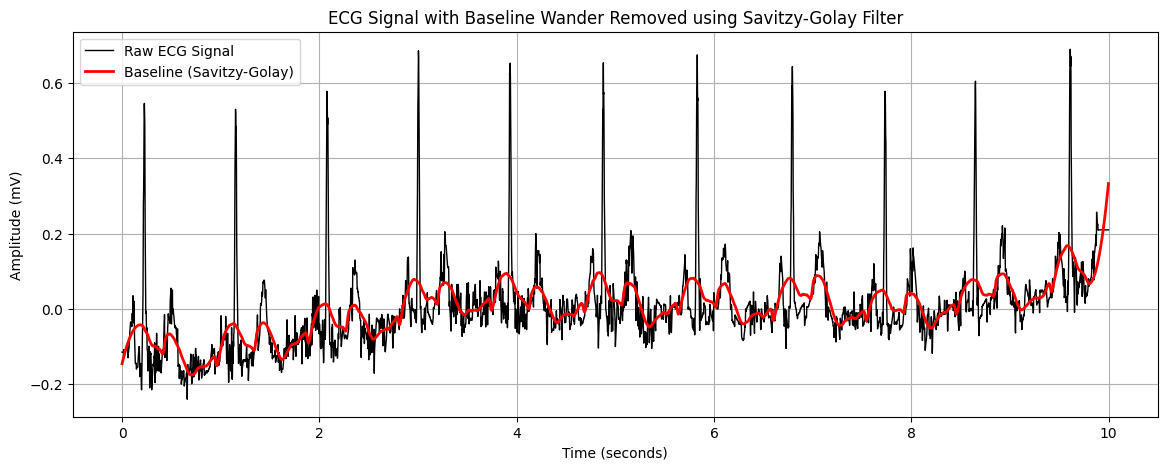

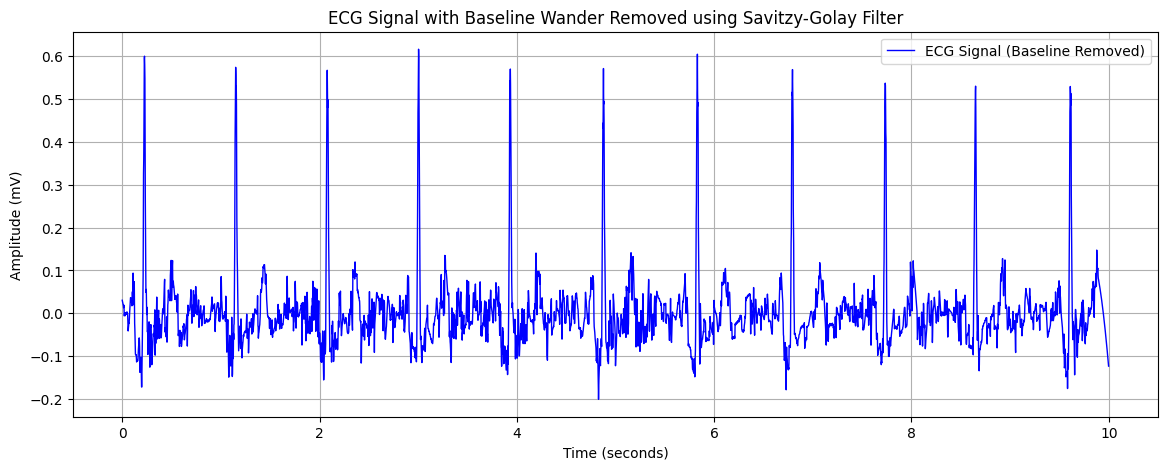

In [103]:
# ------------------------------------------
# Plotting raw ECG signal and baseline with Savitzy-Golay filter
# ------------------------------------------
#152 AF
#1 NORM
record = wfdb.rdrecord(ECG_INDEX[1])
fs = record.fs
ecg_raw = record.p_signal[:,0]
windows_length = int(0.4 * fs) | 1  
if windows_length % 2 == 0:
    windows_length += 1
baseline = savitzy_golay(ecg_raw, windows_length, 2)
ecg_clean = ecg_raw - baseline
r_peaks = detect_rpeaks(ecg_clean, fs)
rr_ms = rpeaks_to_rr_ms(r_peaks, fs)
rr_features = rr_irregularity_metrics(rr_ms)


print("Combirize the result here with the global metric table to find if it AF or NORM")
print_rr_features(rr_features)

t = np.arange(len(ecg_raw)) / fs

plt.figure(figsize=(14, 5))
plt.plot(t, ecg_raw, color="black", linewidth=1, label="Raw ECG Signal")
plt.plot(t, baseline, color="red", linewidth=2, label="Baseline (Savitzy-Golay)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (mV)")
plt.title("ECG Signal with Baseline Wander Removed using Savitzy-Golay Filter")
plt.legend()
plt.grid(True)
plt.figure(figsize=(14, 5))
plt.plot(t, ecg_clean, color="blue", linewidth=1, label="ECG Signal (Baseline Removed)")


plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (mV)")
plt.title("ECG Signal with Baseline Wander Removed using Savitzy-Golay Filter")
plt.legend()
plt.grid(True)
plt.show()